In [ ]:
from scapy.all import *
import matplotlib.pyplot as plt

packets = sniff(offline='./sample.pcapng')

In [ ]:
# 1. Quantidade de hosts
hosts = set()
for packet in packets:
  if (packet.haslayer('IP')):
    hosts.add(packet['IP'].dst)
    hosts.add(packet['IP'].src)
  elif (packet.haslayer('IPv6')):
    hosts.add(packet['IPv6'].dst)
    hosts.add(packet['IPv6'].src)

print(len(hosts))

In [2]:
# 2. Quantidade de conexões TCP com o three-way handshake efetuado
syn_ack_packets = set()
tcp_connections = 0
for packet in packets:
  if (packet.haslayer('TCP')):
    if (packet.haslayer('IP')):
      ip_version = 'IP'
    else:
      ip_version = 'IPv6'

    src = packet[ip_version].src + str(packet['TCP'].sport)
    dst = packet[ip_version].dst + str(packet['TCP'].dport)

    if (packet['TCP'].flags == 18): # SYN/ACK
      syn_ack_packets.add((src, dst))
    elif ((src, dst) in syn_ack_packets):
      syn_ack_packets.remove((src, dst))
    elif ((dst, src) in syn_ack_packets):
      if (packet['TCP'].flags == 16): # ACK
        tcp_connections += 1
      syn_ack_packets.remove((dst, src))

print(tcp_connections)

#####################################################################

SYN_STATE = 0
SYN_ACK_STATE = 1

tcp_conn_state = {}
tcp_connections = 0
for packet in packets:
  if (packet.haslayer('TCP')):
    if (packet.haslayer('IP')):
      ip_version = 'IP'
    else:
      ip_version = 'IPv6'

    src = packet[ip_version].src + str(packet['TCP'].sport)
    dst = packet[ip_version].dst + str(packet['TCP'].dport)

    if (packet['TCP'].flags == 2): # SYN
      tcp_conn_state[(src, dst)] = SYN_STATE
    elif (packet['TCP'].flags == 18): # SYN/ACK
      if ((dst, src) in tcp_conn_state):
        if (tcp_conn_state[(dst, src)] == SYN_STATE):
          tcp_conn_state[(dst, src)] = SYN_ACK_STATE
        else:
          tcp_conn_state.pop((dst, src))
      elif ((src, dst) in tcp_conn_state):
        tcp_conn_state.pop((src, dst))
    elif (packet['TCP'].flags == 16): # ACK
      if ((src, dst) in tcp_conn_state):
        if (tcp_conn_state[(src, dst)] == SYN_ACK_STATE):
          tcp_connections += 1
        tcp_conn_state.pop((src, dst))
      elif ((dst, src) in tcp_conn_state):
        tcp_conn_state.pop((dst, src))
    else:
      if ((src, dst) in tcp_conn_state):
        tcp_conn_state.pop((src, dst))
      elif ((dst, src) in tcp_conn_state):
        tcp_conn_state.pop((dst, src))

print(tcp_connections)

386
372


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 61, 0, 0, 0, 0, 0, 0, 0, 0, 12, 1, 0, 0, 9, 0, 0, 29, 0, 0, 0, 5, 1, 0, 50, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 48, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 9, 9, 2, 8, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 12, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 7, 0, 0, 0, 0, 2, 0, 2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 2, 3, 0, 0, 0, 0, 0, 5, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 3, 6, 1, 3, 0, 1, 5, 0, 0, 0, 0, 0, 0, 0, 1, 8, 1, 2, 0, 7, 11, 0,

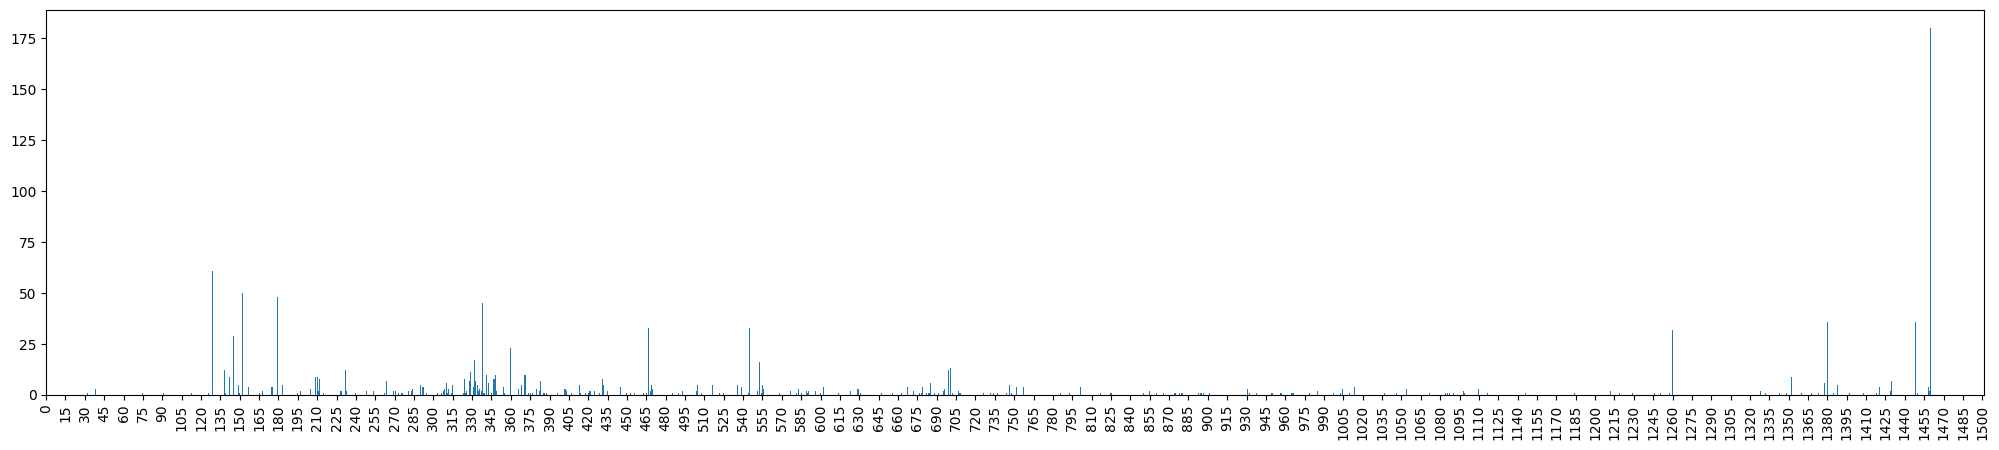

In [14]:
# 3. Histograma do tamanho das páginas webs
import re

pages_per_size = [0 for _ in range(1501)]
for packet in packets:
  if (packet.haslayer('Raw')):
    try:
      raw_utf8 = packet['Raw'].load.decode('UTF-8')
      if (re.match(r'^HTTP/.{1,3} 200 OK', raw_utf8)):
        pages_per_size[len(raw_utf8)] += 1
    except:
      pass

print(pages_per_size)

plt.figure(figsize=(25,5))
plt.bar([i for i in range(1501)], pages_per_size)
plt.xticks(range(0, 1501, 15), rotation=90)
plt.xlim(0, 1501)
plt.show()

{92: 1, 34: 15, 31: 23, 4: 362, 42: 10, 54: 4, 6: 186, 52: 6, 56: 8, 143: 1, 39: 9, 85: 5, 49: 7, 148: 1, 40: 7, 8: 157, 20: 24, 78: 2, 63: 5, 50: 5, 5: 214, 13: 39, 9: 54, 33: 8, 46: 9, 155: 2, 22: 35, 10: 126, 65: 5, 163: 1, 429: 1, 62: 3, 7: 93, 24: 23, 16: 49, 195: 1, 93: 2, 130: 3, 112: 2, 175: 1, 66: 5, 14: 70, 26: 10, 60: 6, 29: 9, 1884: 1, 18: 38, 464: 1, 15: 32, 12: 98, 83: 2, 38: 5, 377: 1, 80: 3, 30: 21, 1882: 1, 19: 17, 28: 13, 37: 12, 89: 4, 25: 17, 23: 22, 94: 2, 48: 10, 35: 5, 76: 3, 1235: 1, 21: 23, 11: 47, 36: 10, 27: 15, 158: 2, 1251: 1, 1229: 1, 70: 10, 124: 1, 17: 29, 103: 6, 74: 6, 69: 4, 67: 10, 44: 6, 113: 3, 32: 6, 43: 10, 342: 1, 141: 2, 84: 3, 531: 1, 41: 5, 193: 1, 53: 8, 104: 2, 120: 2, 106: 2, 105: 2, 57: 3, 1033: 1, 530: 1, 706: 1, 172: 1, 207: 1, 115: 3, 416: 1, 100: 5, 45: 5, 64: 4, 3132: 1, 97: 2, 59: 4, 1232: 1, 410: 1, 82: 2, 98: 1, 248: 1, 1769: 1, 274: 1, 140: 1, 126: 2, 119: 1, 135: 1, 79: 3, 154: 1, 111: 1, 91: 1, 87: 4, 179: 1, 131: 1, 176: 1, 61

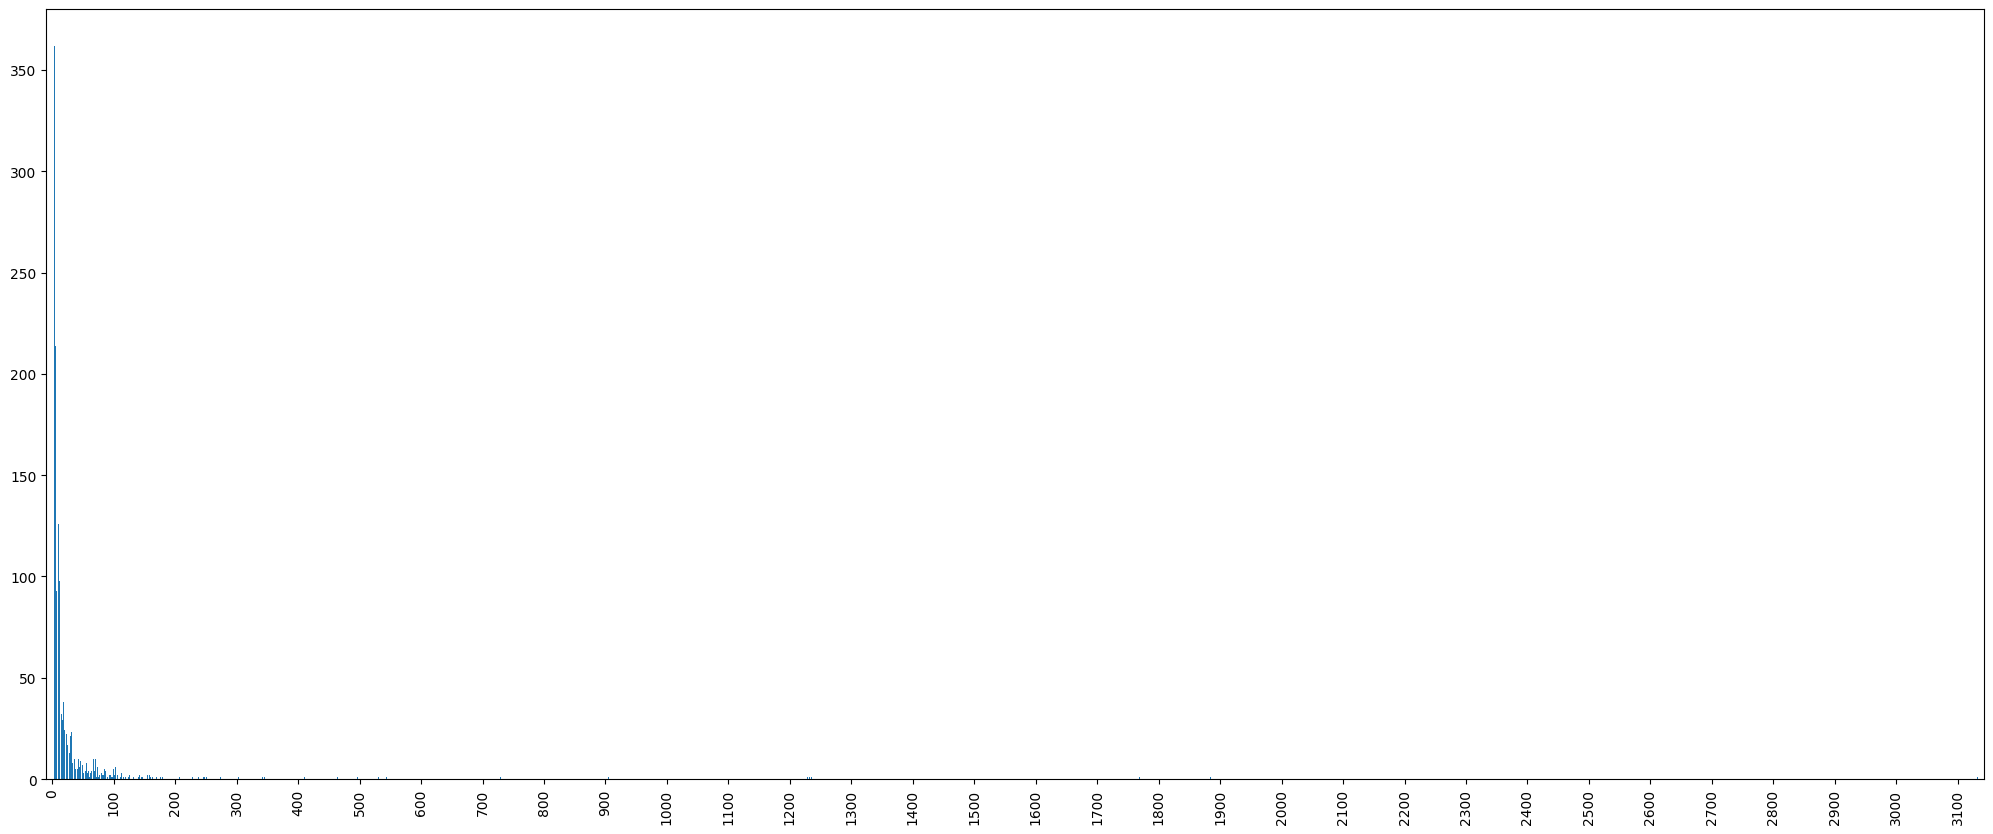

In [23]:
# 4. Histograma da quantidade de pacotes trocadas em conexões TCP
packets_per_session = {}
for packet in packets:
  if (packet.haslayer('TCP')):
    if (packet.haslayer('IP')):
      ip_v = 'IP'
    else:
      ip_v = 'IPv6'

    src = f"{packet[ip_v].src}-{packet['TCP'].sport}"
    dst = f"{packet[ip_v].dst}-{packet['TCP'].dport}"

    if (f"{src} {dst}" in packets_per_session):
      packets_per_session[f"{src} {dst}"] += 1
    elif (f"{dst} {src}" in packets_per_session):
      packets_per_session[f"{dst} {src}"] += 1
    else:
      packets_per_session[f"{src} {dst}"] = 1

packets_per_session_frequency = {}
for packets_per_session in packets_per_session.values():
  if (packets_per_session in packets_per_session_frequency):
    packets_per_session_frequency[packets_per_session] += 1
  else:
    packets_per_session_frequency[packets_per_session] = 1

for i in range(1, 4):
  packets_per_session_frequency.pop(i)
print(packets_per_session_frequency)

plt.figure(figsize=(25,10))
plt.bar(packets_per_session_frequency.keys(), packets_per_session_frequency.values())
plt.xticks(range(0, max(packets_per_session_frequency), 100), rotation=90)
plt.xlim(-10, max(packets_per_session_frequency) + 10)
plt.show()

[('192.168.47.171', 72), ('192.168.47.200', 72), ('192.168.7.17', 63), ('2001:470:765b::b15:22', 62), ('192.168.7.15', 53), ('2001:48a8:6880::18', 32), ('192.168.7.12', 20), ('193.24.227.230', 19), ('2620:fe::fe', 18), ('2001:470:765b:0:1c6e:18ae:ddb4:3bc1', 18)]


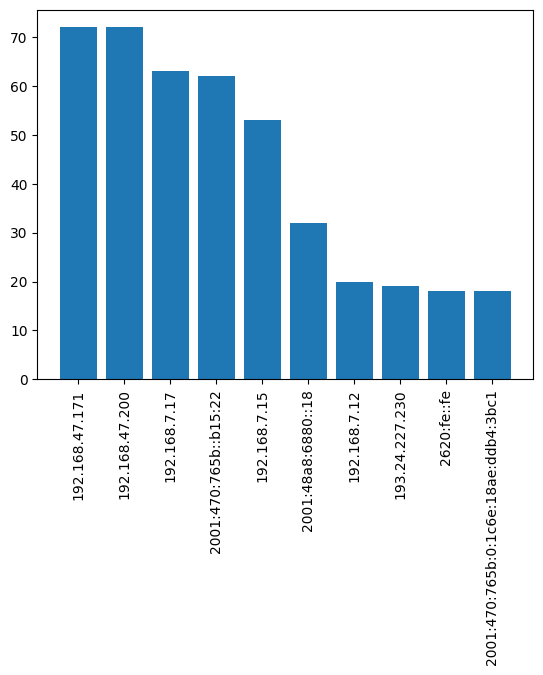

In [17]:
# 5. Gráfico com os 10 hosts com a maior quantidade de conexões com three-way handshake efetuado
SYN_STATE = 0
SYN_ACK_STATE = 1

tcp_conn_state = {}
tcp_connections_per_host = {}
for packet in packets:
  if (packet.haslayer('TCP')):
    if (packet.haslayer('IP')):
      ip_version = 'IP'
    else:
      ip_version = 'IPv6'

    src = packet[ip_version].src + str(packet['TCP'].sport);
    dst = packet[ip_version].dst + str(packet['TCP'].dport);

    if (packet['TCP'].flags == 2): # SYN
      tcp_conn_state[(src, dst)] = SYN_STATE
    elif (packet['TCP'].flags == 18): # SYN/ACK
      if ((dst, src) in tcp_conn_state):
        if (tcp_conn_state[(dst, src)] == SYN_STATE):
          tcp_conn_state[(dst, src)] = SYN_ACK_STATE
        else:
          tcp_conn_state.pop((dst, src))
      elif ((src, dst) in tcp_conn_state):
        tcp_conn_state.pop((src, dst))
    elif (packet['TCP'].flags == 16): # ACK
      if ((src, dst) in tcp_conn_state):
        if (tcp_conn_state[(src, dst)] == SYN_ACK_STATE):
          # Alteração em relação a atividade #2
          ip_src = packet[ip_version].src
          if (ip_src in tcp_connections_per_host):
            tcp_connections_per_host[ip_src] += 1
          else:
            tcp_connections_per_host[ip_src] = 1
          ip_dst = packet[ip_version].dst
          if (ip_dst in tcp_connections_per_host):
            tcp_connections_per_host[ip_dst] += 1
          else:
            tcp_connections_per_host[ip_dst] = 1
          ##
        tcp_conn_state.pop((src, dst))
      elif ((dst, src) in tcp_conn_state):
        tcp_conn_state.pop((dst, src))
    else:
      if ((src, dst) in tcp_conn_state):
        tcp_conn_state.pop((src, dst))
      elif ((dst, src) in tcp_conn_state):
        tcp_conn_state.pop((dst, src))

sorted_tcp_connections_per_host = sorted(tcp_connections_per_host.items(), key=lambda item: item[1], reverse=True)
top_10_tcp_connections_per_host = sorted_tcp_connections_per_host[:10]
print(top_10_tcp_connections_per_host)

plt.bar([t[0] for t in top_10_tcp_connections_per_host],
        [t[1] for t in top_10_tcp_connections_per_host])
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 6. Hosts com webserver executando em porta não convencional (80)
hosts = set()
for packet in packets:
  if (packet.haslayer('TCP') and packet.haslayer('Raw')):
    if (packet['TCP'].sport != 80):
      try:
        raw_utf8 = packet['Raw'].load.decode('utf-8')
        if (raw_utf8.startswith('HTTP/')):
          if (packet.haslayer('IP')):
            ip_v = 'IP'
          else:
            ip_v = 'IPv6'
        hosts.add(packet[ip_v].src)
      except:
        pass

print(len(hosts))
print(hosts)

In [ ]:
# 7. Sessão SSH com a maior quantidade de dados trocados
data_per_session = {}
for packet in packets:
  if (packet.haslayer('TCP') and packet.haslayer('Raw')):
    if (packet.haslayer('IP')):
      ip_v = 'IP'
    else:
      ip_v = 'IPv6'

    src = packet[ip_v].src + '-' + str(packet['TCP'].sport)
    dst = packet[ip_v].dst + '-' + str(packet['TCP'].dport)

    if (packet['TCP'].sport == 22):
      key = (src, dst)
    elif (packet['TCP'].dport == 22):
      key = (dst, src)
    else:
      continue

    if (key in data_per_session):
      data_per_session[key] += len(packet)
    else:
      data_per_session[key] = len(packet)

sorted_data_per_session = sorted(data_per_session.items(), key=lambda item: item[1], reverse=True)
print(sorted_data_per_session)

[('port: 43', 33), ('port: 23', 14), ('port: 443', 14), ('port: 80', 11), ('port: 631', 9)]


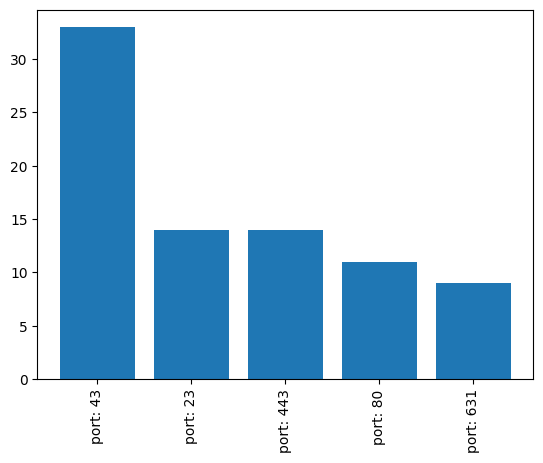

In [6]:
# 8. Gráfico com os 5 serviços com a maior quantidade de sessões TCP finalizadas corretamente
FIN_1_STATE = 0 # A -> B
ACK_1_STATE = 1 # B -> A
FIN_2_STATE = 2 # B -> A
# ACK_2_STATE   # A -> B

tcp_conn_state = {}
fin_conn_per_port = {}
for packet in packets:
  if (packet.haslayer('TCP')
    	and (packet['TCP'].sport < 1024 or packet['TCP'].dport < 1024)):
    if (packet.haslayer('IP')):
      ip_v = 'IP'
    else:
      ip_v = 'IPv6'
    src = (packet[ip_v].src, packet['TCP'].sport)
    dst = (packet[ip_v].dst, packet['TCP'].dport)

    if (packet['TCP'].flags & 1): # FIN
      if ((dst, src) in tcp_conn_state):
        if (tcp_conn_state[(dst, src)] == ACK_1_STATE):
          tcp_conn_state[(dst, src)] = FIN_2_STATE
        else:
          tcp_conn_state.pop((dst, src))
      else:
        tcp_conn_state[(src, dst)] = FIN_1_STATE
    if (packet['TCP'].flags & 16): # ACK
      if ((dst, src) in tcp_conn_state
          and tcp_conn_state[(dst, src)] == FIN_1_STATE):
        tcp_conn_state[(dst, src)] = ACK_1_STATE
      elif ((src, dst) in tcp_conn_state
            and tcp_conn_state[(src, dst)] == FIN_2_STATE):
        tcp_conn_state.pop((src, dst))
        if (packet['TCP'].sport < 1024):
          port = packet['TCP'].sport
        else:
          port = packet['TCP'].dport
        key = f"port: {port}"
        if (key not in fin_conn_per_port):
          fin_conn_per_port[key] = 0
        fin_conn_per_port[key] += 1
    if (packet['TCP'].flags & 4): # RST
      if ((src, dst) in tcp_conn_state):
        tcp_conn_state.pop((src, dst))
      elif ((dst, src) in tcp_conn_state):
        tcp_conn_state.pop((dst, src))

sorted_fin_conn_per_port = sorted(fin_conn_per_port.items(), key=lambda item: item[1], reverse=True)
top_5_fin_conn_per_port = sorted_fin_conn_per_port[:5]
print(top_5_fin_conn_per_port)

plt.bar([t[0] for t in top_5_fin_conn_per_port],
        [t[1] for t in top_5_fin_conn_per_port])
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 1. Ocorrencia de login no telnet


In [ ]:
# 2. Resolução de nome para um blog
name_ip = set()
for packet in packets:
  if (packet.haslayer('DNS')
      and packet.haslayer('DNS Resource Record')
      and b'blog' in packet['DNS Resource Record'].rrname):
    blog_domain = packet['DNS Resource Record'].rrname
    blog_ip = packet['DNS Resource Record'].rdata
    name_ip.add(f"{blog_domain} == {blog_ip}")

name_ip

In [ ]:
# 3. ARP Spoof (ou um aparente spoofing de MAC address)


In [ ]:
# 4. Hosts envolvidos em possível DHCP spoofing


[('192.168.75.1->192.168.75.132', 1000), ('10.82.185.11->5.35.226.136', 7), ('2001:470:765b:0:1965:111f:4398:d558->2a01:488:42:1000:50ed:8588:8a:c570', 4), ('2a01:238:4363:ee00:9169:a8a4:e572:d5f8->2001:470:1f0a:319::2', 4), ('85.215.94.29->37.24.166.89', 4), ('216.66.80.30->193.24.227.12', 3), ('192.168.7.1->192.168.7.12', 2), ('2003:de:2016:125:fc36:8317:4e86:cb72->2003:de:2016:110::a12:443', 2), ('2003:de:2016:125:fc36:8317:4e86:cb72->2003:de:2016:120::a08:53', 2), ('172.16.23.2->192.168.47.1', 2)]


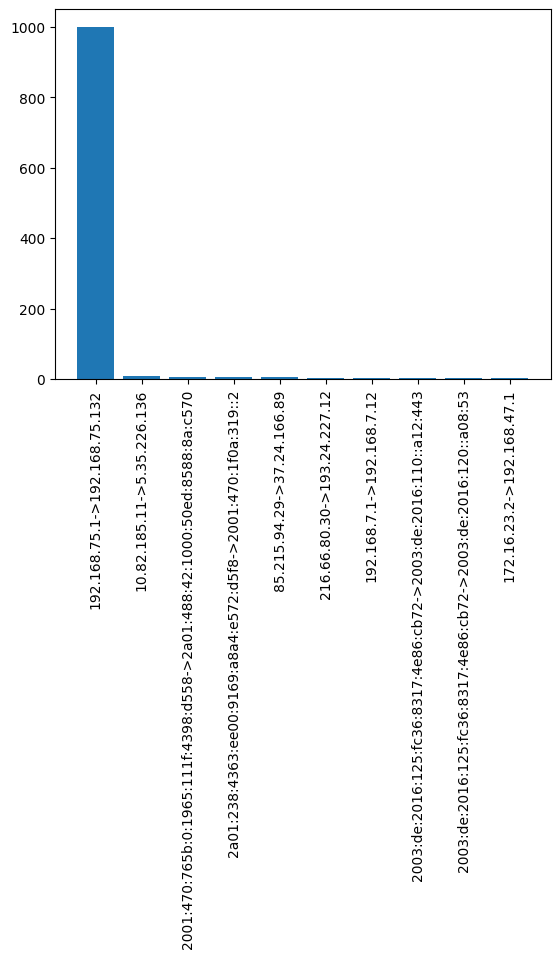

In [22]:
# 5. Hosts efetuando SYNScan, exiba através de um gráfico
dports_per_ips = {}
for packet in packets:
  if (packet.haslayer('TCP')
      and packet['TCP'].flags == 2): # SYN
    if (packet.haslayer('IP')):
      ip_v = 'IP'
    else:
      ip_v = 'IPv6'

    key = f"{packet[ip_v].src}->{packet[ip_v].dst}"
    if (key not in dports_per_ips):
      dports_per_ips[key] = set()
    dports_per_ips[key].add(packet['TCP'].dport)

dport_amount_per_ips = {}
for ips, dports in dports_per_ips.items():
  dport_amount_per_ips[ips] = len(dports)

sorted_dport_amount_per_ips = sorted(dport_amount_per_ips.items(), key=lambda item: item[1], reverse=True)
top_10_dport_amount_per_ips = sorted_dport_amount_per_ips[:10]
print(top_10_dport_amount_per_ips)

plt.bar([t[0] for t in top_10_dport_amount_per_ips],
        [t[1] for t in top_10_dport_amount_per_ips])
plt.xticks(rotation=90)
plt.show()